This notebook can be used to do a visual sanity check on how good the model is doing in detecting marching band members.

### Imports

In [1]:
import os
import sys
import glob
import torch
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader

# our code
sys.path.append("..")
from src.detectron2_classes.CustomDatasetMapper import CustomDatasetMapper
from src.inference import register_inference_instances, draw_detections, nms_all_classes

/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO

In [2]:
# fill in the path on your machine
annotations_folder = "/data/huanga/Synchrony/annotations" # the folder containing the annotations
images_folder = "/data/huanga/Synchrony/annotations/annotated_images" # the folder containing the annotated images (must match the annotations)
models_folder = "/data/huanga/Synchrony/models" # the folder containing the checkpoints of the models
model_name = "best_model" # the name of the model you want to use

os.makedirs(annotations_folder, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)
os.makedirs(models_folder, exist_ok=True)

### Build the model

In [3]:
# Name of model to evaluate
cfg = get_cfg()
yaml_file =  os.path.join(models_folder, model_name, 'config.yaml')
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False
weights_path = sorted(glob.glob(os.path.join(models_folder, model_name, "best-model-config-iter-*.pth")))[0]
cfg.MODEL.DEVICE="cuda"
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 20000
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
print(weights_path)

# build the model
model = build_model(cfg)
_ = model.eval()
checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

/data/huanga/Synchrony/models/best_model/best-model-config-iter-3071-loss-0.672501820996827.pth


### Build the dataloader

In [4]:
frame_files = sorted(glob.glob(os.path.join(images_folder, "*.jpg")))
print(f"Found {len(frame_files)} frames.")
frame_inds = [10, 20, 30] 
frame_files = [frame_files[ind] for ind in frame_inds]

# build the loader
register_inference_instances("visualize", frame_files)
mapper = CustomDatasetMapper(cfg, is_train=False)
loader = build_detection_test_loader(cfg, "visualize", mapper=mapper)

Found 163 frames.


/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


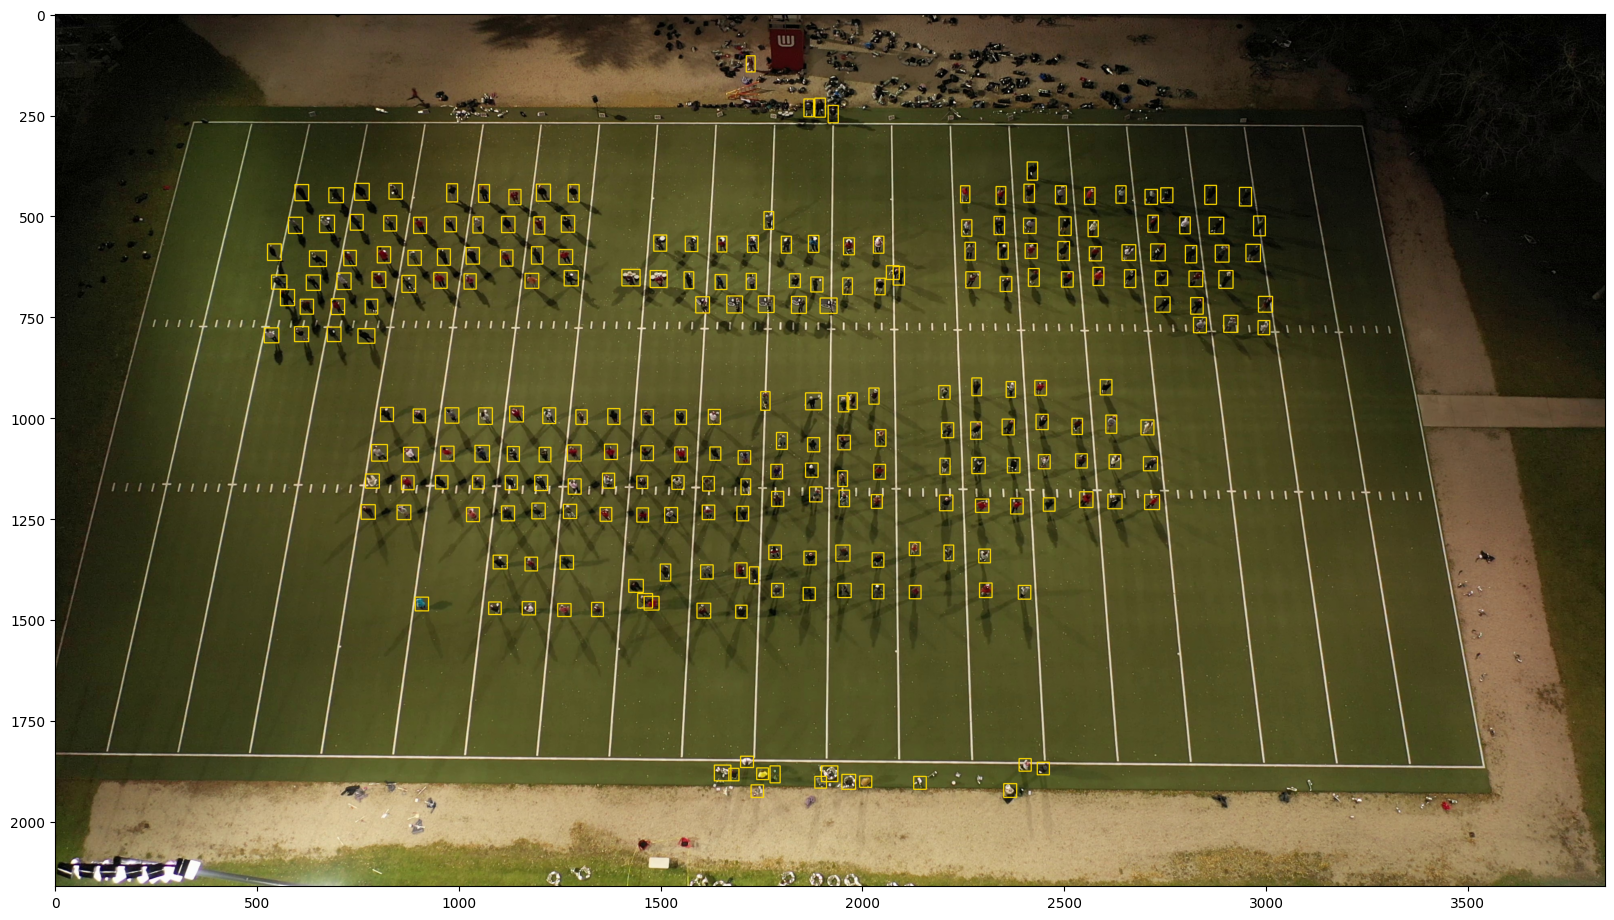

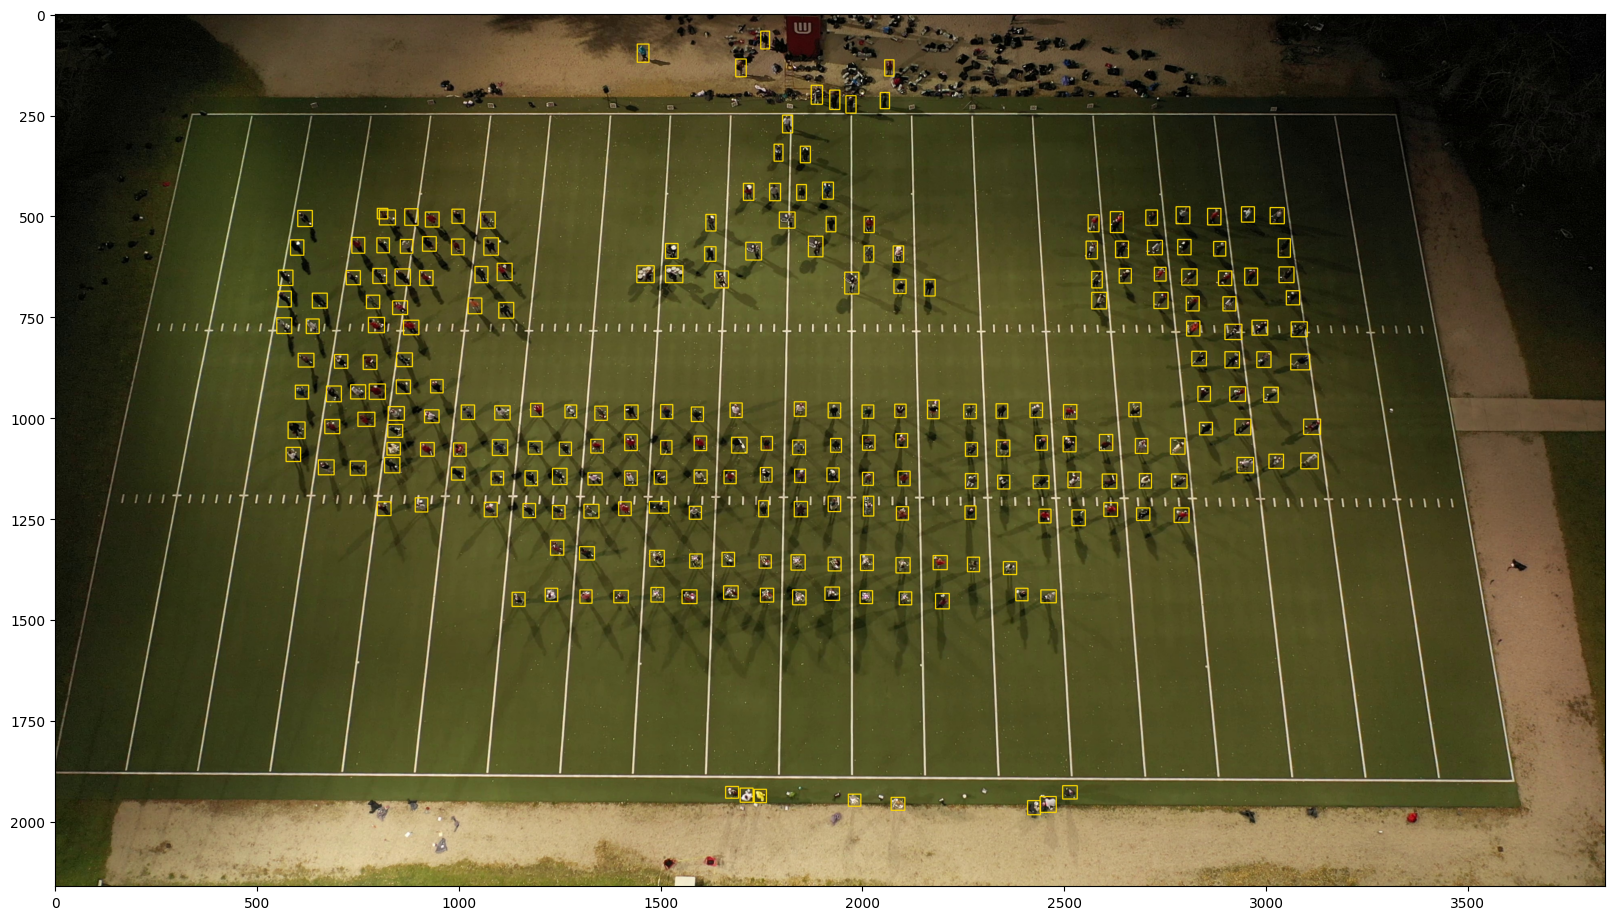

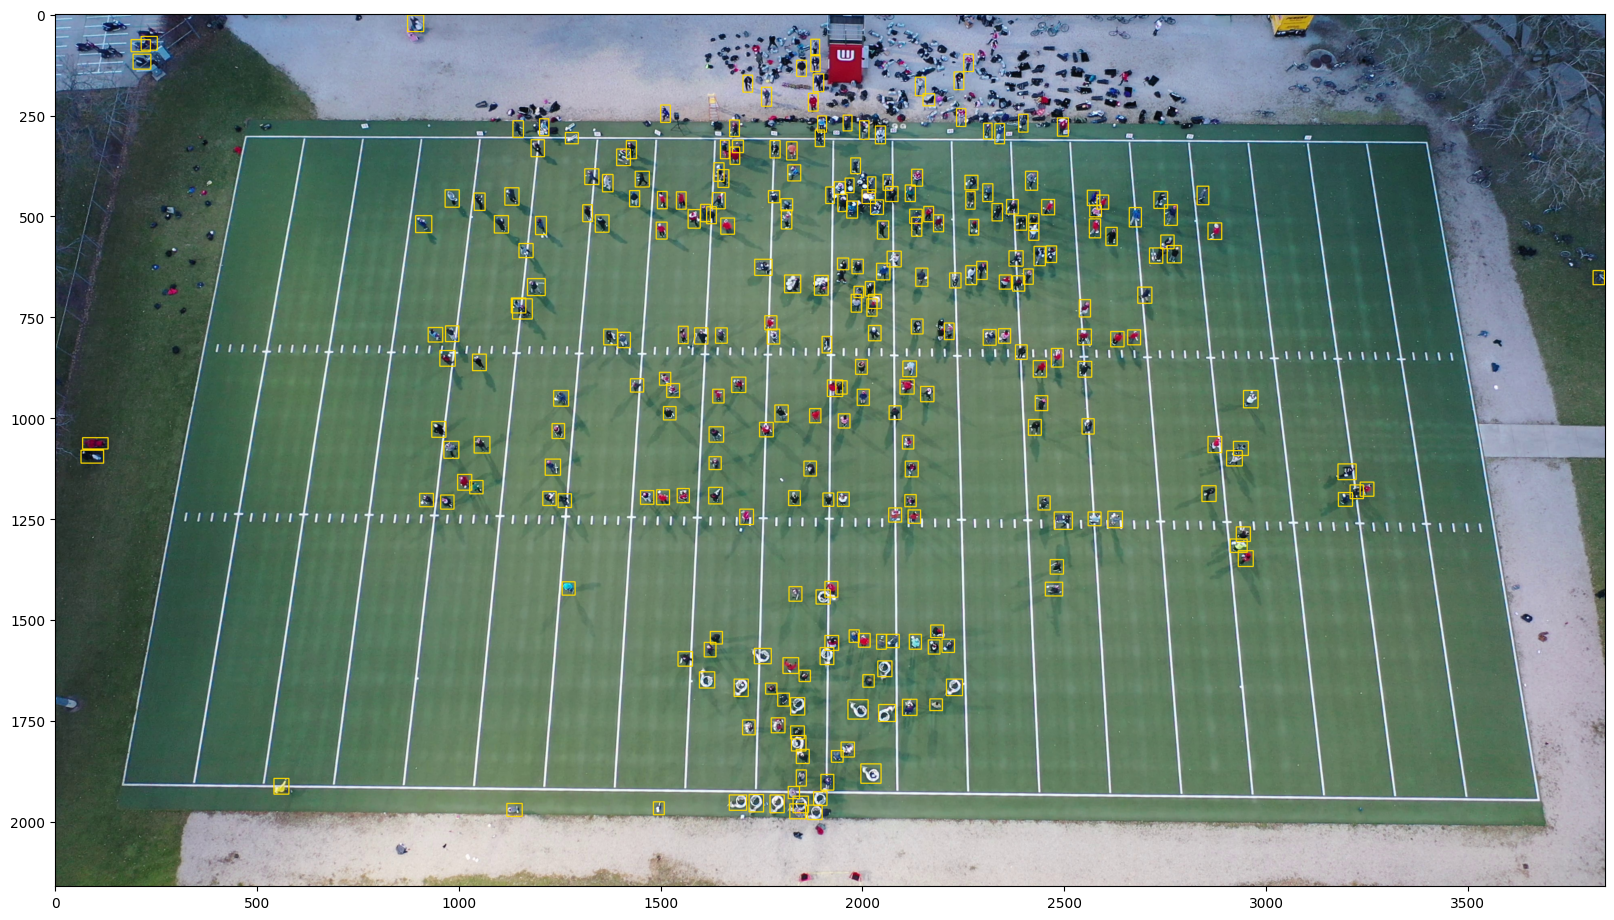

In [5]:
# visualize the results
all_detections = []
colors = [(255, 218, 0), (27, 179, 255), (255, 255, 255)]
with torch.no_grad():
    for batch_num, image_batch in enumerate(loader):
        detections = model(image_batch)
        for detection, im in zip(detections, image_batch):
            instances = detection['instances']
            instance = nms_all_classes(instances, iou_thresh=.5)
            im = draw_detections(im, instances, min_score=.7, colors=colors, thickness=2)
            plt.figure(figsize=(20,20))
            plt.imshow(im)